# Unsupervised Learning EDSA Movie Recommendation

### Table of Contents
---
1. [Introduction](#intro)
 * Background
 * Problem Statement
---
2. [Load Dependencies](#imports)
 * Connecting to Comet
 * Libraries
 * Data
 * Data Definitions
---
3. [Exploratory Data Analysis](#EDA)
 * Data Summary
 * Missing Values
 * Ratings
 * Genres
 * IMDB Metadata
---
4. [Data Preprocessing](#preprocessing)
 * Multidimensional Scaling
 * Principle Component Analysis
 * Cluster Analysis
---
5. [Modelling](#modelling)
 * Collaborative Filtering
 * Content-based Filtering
---
6. [Performance Evaluation](#evaluation)
 * Root Mean Squared Error (RMSE)
 * Cross Validation
---
7. [Model Analysis](#analysis)
 * Hyperparameter Tuning
 * Results
---
8. [Conclusion](#conclusion)
---
9. [Save Output](#ref)
---
10. [References](#save)
--- 

<a id="intro"></a>
## 1. Introduction  

### Background

In today's technology driven world, recommender systems are critical to ensuring users can make appropriate decisions about the content they engage with daily.

Recommender systems help users select similar items when something is being chosen online. Netflix or Amazon would suggest different movies and titles that might interest individual users. In education, these systems may be used to suggest learning material that could improve educational outcomes. These types of algorithms lead to service improvement and customer satisfaction. They do this by addressing the long-tail problem shown below.

<img src="https://www.golegal.co.za/wp-content/uploads/2022/04/Picture2-1.png" width="500" align="center">
    
Customers do not have the time to browse through every available product and businesses cannot simply stop supplying less popular products. A recommender system addresses the long-tail problem by recommending less popular content that the customer is likely to rate highly.

Current recommendation systems - content-based filtering and collaborative  filtering - use difference information sources to make recommendations [[1]](#ref1).

#### Content-based filtering

This method makes recommendations based on user preferences for product features. It is able to recommend new items, but is limited by the need for more data of user preference to improve the quality of recommendations.

#### Collaborative filtering

Collaborative filtering mimics user-to-user recommendations. In other words, If you and your friend have similar tastes, you are likely to make recommendations the other would approve of. This method finds similar users and predicts their preferences as a linear, weighted combination of other user preferences. The limitation is the requirement of a large dataset with active useres who rated a product before in order to make accurate predictions. As a result of this limitation, collaborative systems usually suffer from the "cold start" problem, making predictions for new users challenging. This is usually overcome by using content-based filtering to initiate a user profile.

#### Hybrid systems

A combination of these two recommendations systems is called a hybrid system. They mix the features of the item itself and the preferences of other users [[2]](#ref2).

### Problem Statement
Construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed, based on their historical preferences.

<img src="https://research.aimultiple.com/wp-content/webp-express/webp-images/uploads/2017/08/recommendation-system-800x450.png.webp"
    alt="Dummy image 1"
     style="float: center; padding-bottom=0.5em"
     width=500px/>

<a id="imports"></a>
## 2. Load Dependencies

### Libriaries

In [83]:
#comet section

In [84]:
# Exploratory Data Analysis
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing
import random
from time import time
#import cufflinks as cf
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn.preprocessing import StandardScaler
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Models
#from surprise import Reader, Dataset
#from surprise import SVD, NormalPredictor, BaselineOnly, NMF, SlopeOne, CoClustering
#from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.feature_extraction.text import CountVectorizer

# Performance Evaluation
#from surprise import accuracy
#from sklearn.metrics import mean_squared_error
#from surprise.model_selection import GridSearchCV, cross_validate, train_test_split

# Ignore warnings
import warnings
warnings.simplefilter(action='ignore')

### Loading the Data

#### Train and test data:
This is the data used for training and Kaggle submission purposes. The rating is the target variable.

In [85]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print(train_df.shape, test_df.shape)
train_df.head()

(1048575, 4) (1048575, 2)


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


#### Movie Dataset

In [86]:
movies_df =  pd.read_csv('movies.csv', index_col='movieId')
imdb_df =  pd.read_csv('imdb_data.csv', index_col='movieId')
links_df =  pd.read_csv('links.csv', index_col='movieId')
genome_scores =  pd.read_csv('genome_scores.csv', index_col='movieId')
genome_tags =  pd.read_csv('genome_tags.csv', index_col='tagId')
tags =  pd.read_csv('tags.csv')
print(movies_df.shape, imdb_df.shape, links_df.shape, genome_scores.shape, genome_tags.shape)

(62423, 2) (27278, 5) (62423, 2) (15584448, 2) (1128, 1)


<a id="EDA"></a>
## 3. Exploratory Data Analysis

In [87]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1048575 non-null  int64  
 1   movieId    1048575 non-null  int64  
 2   rating     1048575 non-null  float64
 3   timestamp  1048575 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 32.0 MB


In [88]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   userId   1048575 non-null  int64
 1   movieId  1048575 non-null  int64
dtypes: int64(2)
memory usage: 16.0 MB


In [89]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62423 entries, 1 to 209171
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   62423 non-null  object
 1   genres  62423 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [90]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27278 entries, 1 to 131262
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title_cast     17210 non-null  object 
 1   director       17404 non-null  object 
 2   runtime        15189 non-null  float64
 3   budget         7906 non-null   object 
 4   plot_keywords  16200 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.2+ MB


In [91]:
links_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62423 entries, 1 to 209171
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   imdbId  62423 non-null  int64  
 1   tmdbId  62316 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.4 MB


In [92]:
genome_scores.head()

,tagId,relevance
movieId,,
1,1,0.02875
1,2,0.02375
1,3,0.06250
1,4,0.07575
1,5,0.14075


In [93]:
genome_tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128 entries, 1 to 1128
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tag     1128 non-null   object
dtypes: object(1)
memory usage: 17.6+ KB


In [94]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int64 
 1   movieId    1093360 non-null  int64 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.4+ MB


In [95]:
print("Train: ")
print(str(train_df.isnull().sum()))
print("============")
print("Test: ")
print(str(test_df.isnull().sum()))
print("============")
print("Movies: ")
print(str(movies_df.isnull().sum()))
# print("============")
# print("Tags: ")
# print(str(tags_df.isnull().sum()))
print("============")
print("Links: ")
print(str(links_df.isnull().sum()))
print("============")
print("IMDB: ")
print(str(imdb_df.isnull().sum()))
print("============")
print("Genome scores: ")
print(str(genome_scores.isnull().sum()))
print("============")
print("Genome tags: ")
print(str(genome_tags.isnull().sum()))
print("============")
print("tags: ")
print(str(tags.isnull().sum()))

Train: 
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Test: 
userId     0
movieId    0
dtype: int64
Movies: 
title     0
genres    0
dtype: int64
Links: 
imdbId      0
tmdbId    107
dtype: int64
IMDB: 
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64
Genome scores: 
tagId        0
relevance    0
dtype: int64
Genome tags: 
tag    0
dtype: int64
tags: 
userId        0
movieId       0
tag          16
timestamp     0
dtype: int64


In [96]:
# Drop missing rows
# tags_df.dropna(axis=0,inplace=True)
links_df.dropna(axis=0,inplace=True)
tags.dropna(axis=0,inplace=True)

Qs: Here we check which users have rated the most movies?

In [97]:
def user_ratings_count(df, n):
    plt.figure(figsize=(12,10))
    data = df['userId'].value_counts().head(n)
    ax = sns.barplot(x = data.index, y = data, order= data.index, palette='brg', edgecolor="black")
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=12, ha='center', va='bottom')
    plt.title(f'Top {n} Users by Number of Ratings', fontsize=14)
    plt.xlabel('User ID')
    plt.ylabel('Number of Ratings')
    print("Combined number of ratings:\t",df['userId'].value_counts().head(n).sum(),
         "\nTotal number of movies:\t\t", df['movieId'].nunique())
    plt.show()

Combined number of ratings:	 4110 
Total number of movies:		 23620


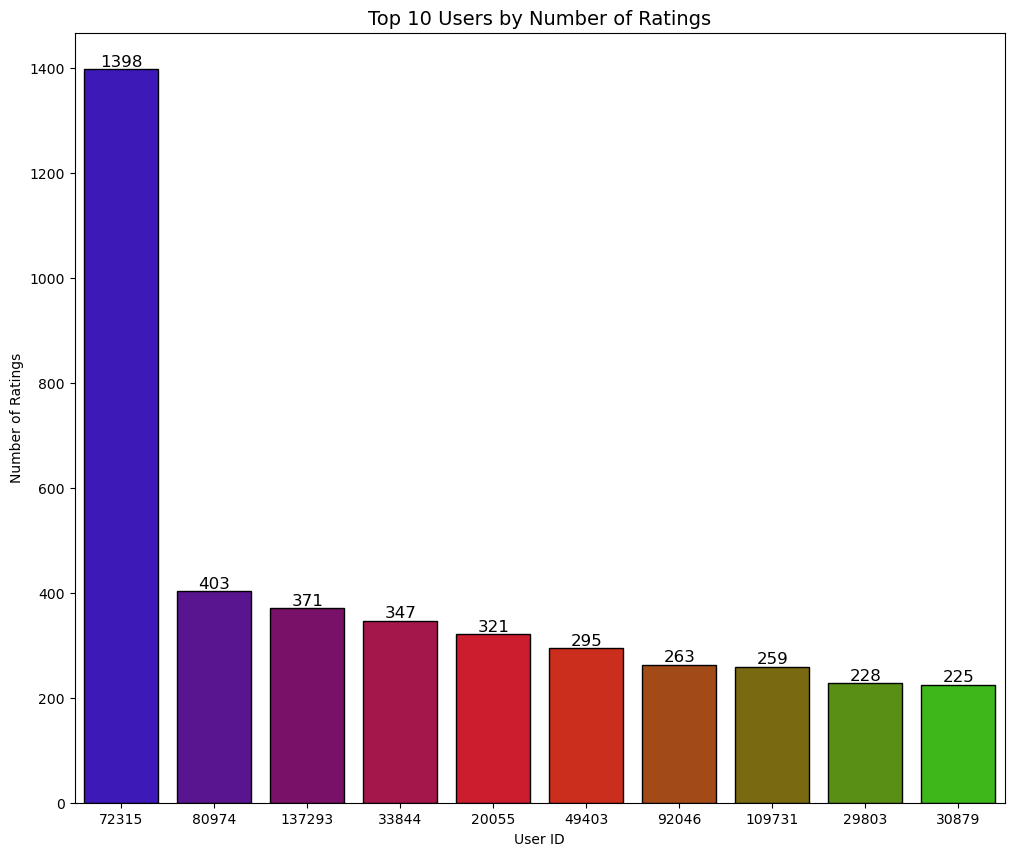

In [98]:
user_ratings_count(train_df,10)

In [99]:
# Exclude user 72315 for EDA
# user 72315 is considered as outlier/anomaly/noise within the data frame.
eda_df = train_df[train_df['userId']!=72315]

Combined number of ratings:	 2936 
Total number of movies:		 22938


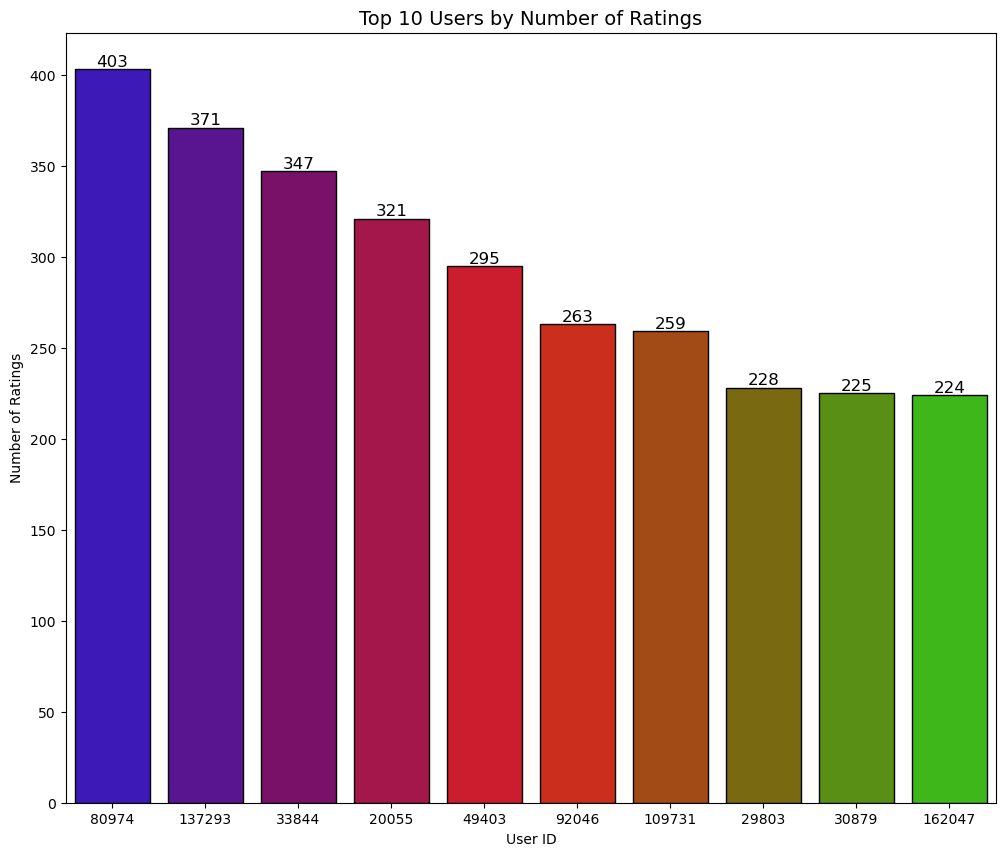

In [100]:
# Distribution of ratings without the outliers
user_ratings_count(eda_df,10)

In [101]:
# How many ratings have we lost?
ratings_lost = 38970 - 28296
print(ratings_lost)  ## ratings lost from removing the outlier

10674


In [102]:
# How many movies were only rated by our outlier?
movies_lost = 48213 -45844
print(movies_lost)   # movies lost from removing the outlier

2369


Qs:Here we check how do users tend to rate movies?

In [103]:
def ratings_distplot(df, column='rating'):
    plt.figure(figsize=(8,6))
    ax = sns.distplot(df[f'{column}'],bins=10, kde=False, hist_kws=dict(alpha=0.6),color="#4D17A0")
    mean = df[f'{column}'].mean()
    median = df[f'{column}'].median()
    plt.axvline(x=mean, label = f'mean {round(mean,2)}' , color='#4D17A0', lw=3, ls = '--')
    plt.axvline(x=median, label = f'median {median}' , color='#4DA017', lw=3, ls = '--')
    plt.xlim((0.5,5))
    plt.ylim((0,2500000))
    plt.title(f'Distribution of Ratings', fontsize=16)
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

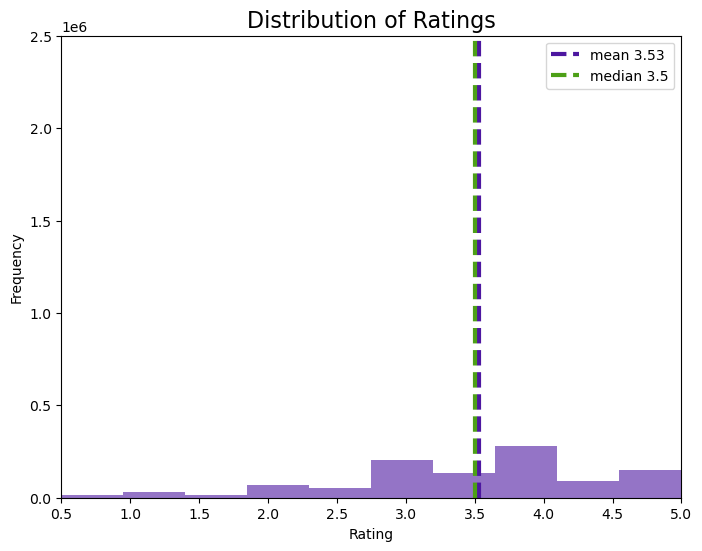

In [104]:
ratings_distplot(eda_df)

We observe an interesting thing that the ratings are left-skewed. It was expected that there would be a normal distrubtion with a mean rating of 3. However, we observe that users tend to rate movies quite favourably and tend to avoid negative ratings. This skew might be explained by the tendency of users to rate movies they liked. In other words, if a user doesn't like a movie, it is unlikely that they will watch it through to the end, let alone rate it.

Qs:Here we check if there is a relationship between the number of movies a user has rated and the rating that they give?

In [105]:
def mean_ratings_scatter(df, color='#4DA017', column='userId'):
    plt.figure(figsize=(6,4))
    mean_ratings = df.groupby(f'{column}')['rating'].mean()
    user_counts = df.groupby(f'{column}')['movieId'].count().values
    sns.scatterplot(x=mean_ratings, y = user_counts, color=color)
    plt.title(f'Mean Ratings by Number of Ratings', fontsize=14)
    plt.xlabel('Rating')Qs:Here we check if there is a relationship between the number of movies a user has rated and the rating that they give?
    plt.ylabel('Number of Ratings')
    plt.show()

Object `give` not found.


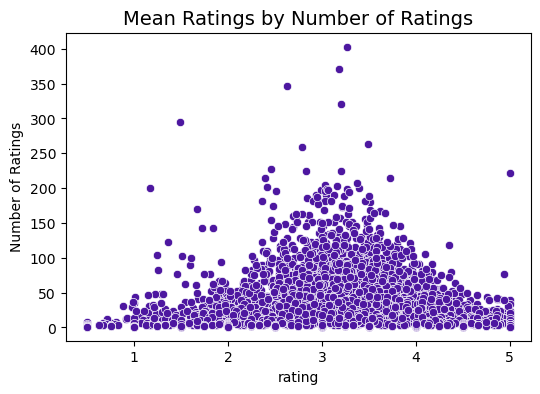

In [106]:
# Mean user ratings by number of ratings
mean_ratings_scatter(eda_df,'#4D17A0')

Qs: Here we check if there is a relationship between the number of ratings a movie has and how highly it is rated?

Object `give` not found.


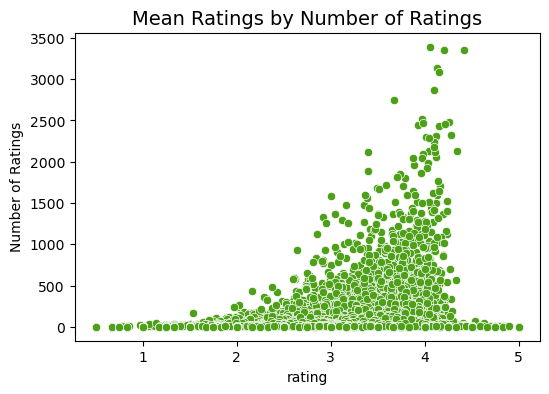

In [107]:
# Mean movie ratings by number of ratings
mean_ratings_scatter(eda_df, column='movieId')

Qs:Here we check which are the best and worst rated movies of all time?

In [108]:
def plot_ratings(count, n, color='#4DA017', best=True, method='mean'):
    # What are the best and worst movies
    # Creating a new DF with mean and count
    if method == 'mean':
        movie_avg_ratings = pd.DataFrame(eda_df.join(movies_df, on='movieId', how='left').groupby(['movieId', 'title'])['rating'].mean())
    else:
        movie_avg_ratings = pd.DataFrame(eda_df.join(movies_df, on='movieId', how='left').groupby(['movieId', 'title'])['rating'].median())
    movie_avg_ratings['count'] = eda_df.groupby('movieId')['userId'].count().values
    movie_avg_ratings.reset_index(inplace=True)
    movie_avg_ratings.set_index('movieId', inplace=True)

    # Remove movies that have been rated fewer than n times
    data = movie_avg_ratings[movie_avg_ratings['count']>count]
    data.sort_values('rating', inplace= True,ascending=False)
    if best == True:
        plot = data.head(n).sort_values('rating', ascending=True)
        title='Best Rated'
    else:
        plot = data.tail(n).sort_values('rating', ascending=False)
        title='Worst Rated'
    plt.figure(figsize=(9,5))
    sns.scatterplot(x=plot['rating'], y=plot['title'], size=plot['count'], color=color)
    plt.xlabel('Rating')
    plt.ylabel('')
    plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
    plt.title(f'Top {n} {title} Movies with Over {count} Ratings', fontsize=20)
    plt.show()

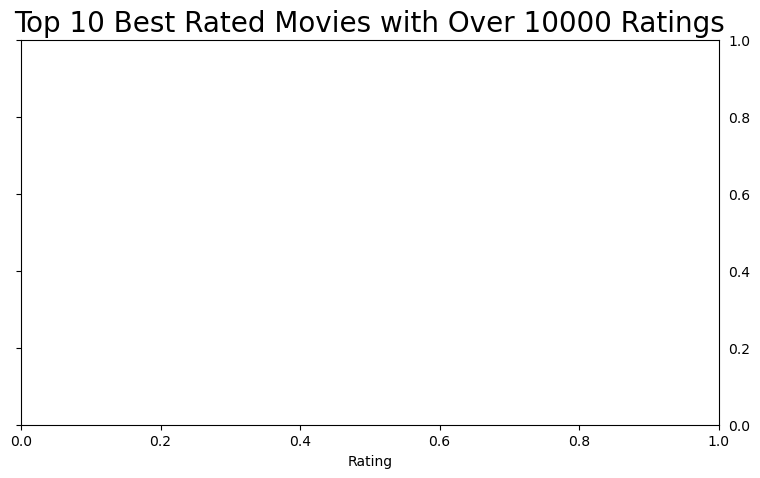

In [109]:
# What are the top 10 highest rated titles?
plot_ratings(10000, 10, '#4D17A0', True, 'mean')

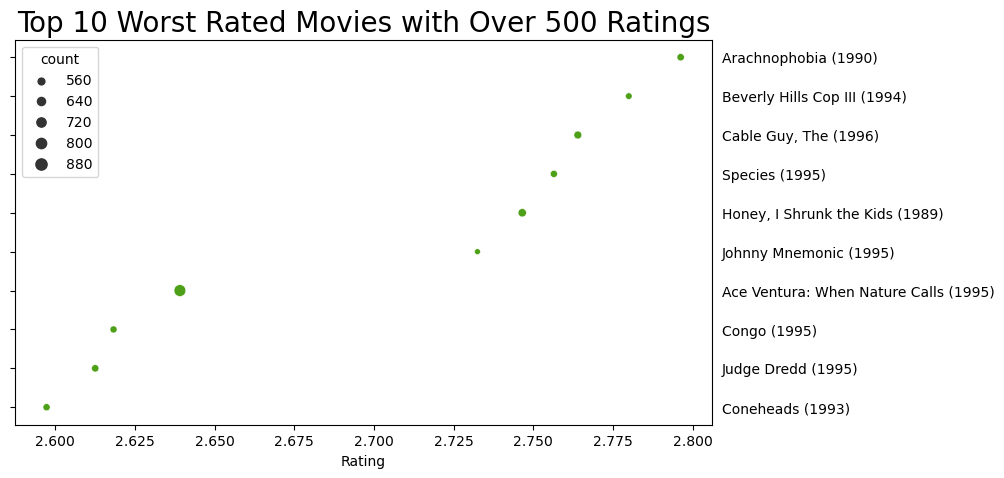

In [110]:
# What are the 10 worst rated titles?
plot_ratings(500, 10,'#4DA017', False, 'mean')

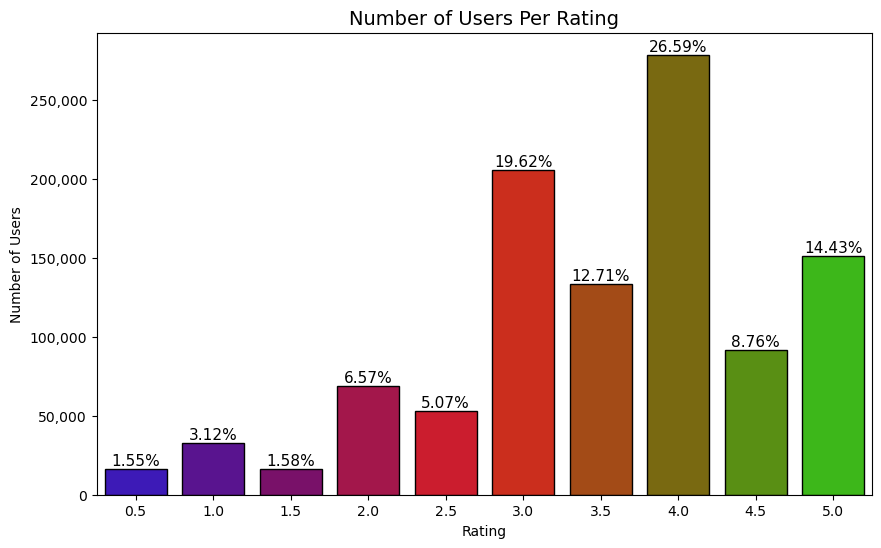

In [111]:
#Percentage of users per rating

movieRatingDistGroup = train_df['rating'].value_counts().sort_index().reset_index()
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=movieRatingDistGroup, x='index', y='rating', palette="brg", edgecolor="black", ax=ax)
ax.set_xlabel("Rating")
ax.set_ylabel('Number of Users')
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
total = float(movieRatingDistGroup['rating'].sum())
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height+350, '{0:.2%}'.format(height/total), fontsize=11, ha="center", va='bottom')
plt.title('Number of Users Per Rating', fontsize=14)
plt.show()

In [112]:
def feature_frequency(df, column):
    # Creat a dict to store values
    df = df.dropna(axis=0)
    genre_dict = {f'{column}': list(),
                 'count': list(),}
    # Retrieve a list of all possible genres
    print('retrieving features...')
    for movie in range(len(df)):
        gens = df[f'{column}'].iloc[movie].split('|')
        for gen in gens:
            if gen not in genre_dict[f'{column}']:
                genre_dict[f'{column}'].append(gen)
    # count the number of occurences of each genre
    print('counting...')
    for genre in genre_dict[f'{column}']:
        count = 0
        for movie in range(len(df)):
            gens = df[f'{column}'].iloc[movie].split('|')
            if genre in gens:
                count += 1
        genre_dict['count'].append(count)
        
        # Calculate metrics
    data = pd.DataFrame(genre_dict)
    print('done!')
    return data
genres = feature_frequency(movies_df, 'genres')

retrieving features...
counting...
done!


In [113]:
def feature_count(df, column):
    plt.figure(figsize=(10,6))
    ax = sns.barplot(y = df[f'{column}'], x = df['count'], palette='brg', orient='h')
    plt.title(f'Number of Movies Per {column}', fontsize=14)
    plt.ylabel(f'{column}')
    plt.xlabel('Count')
    plt.show()

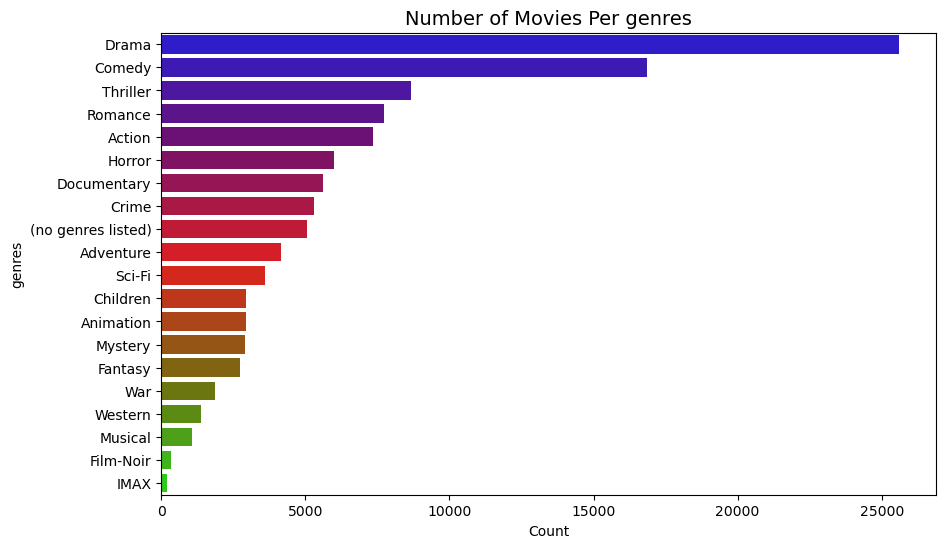

In [114]:
feature_count(genres.sort_values(by = 'count', ascending=False), 'genres')

Qs: Here we check who are the most common directors?

In [115]:
def count_directors(df, count = 10):
    directors = pd.DataFrame(df['director'].value_counts()).reset_index()
    directors.columns = ['director', 'count']
    # Lets only take directors who have made 10 or more movies otherwise we will have to analyze 11000 directors
    directors = directors[directors['count']>=count]
    return directors.sort_values('count', ascending = False)
directors = count_directors(imdb_df)

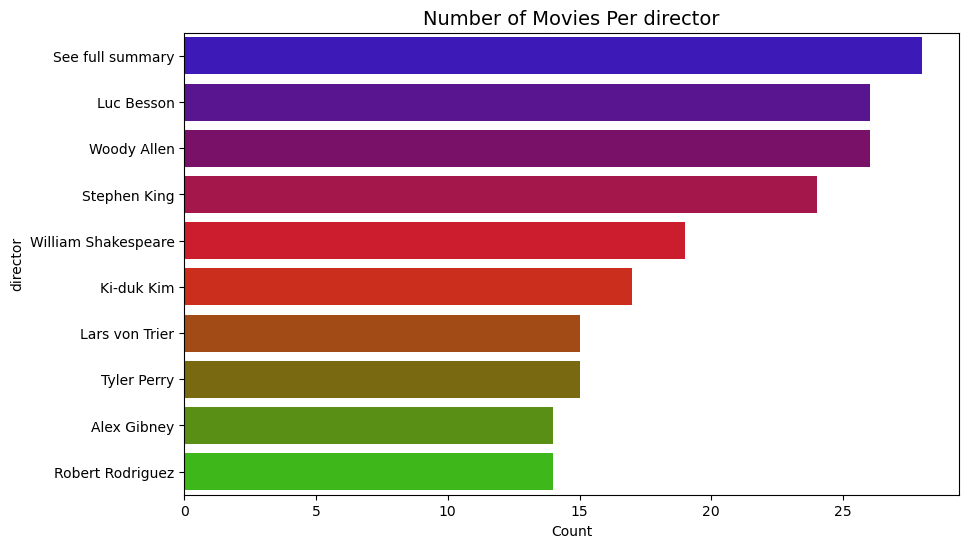

In [116]:
feature_count(directors.head(10), 'director')

In [117]:
def dir_mean(df):
    df.set_index('director', inplace=True)

    direct_ratings = []
    directors_eda = eda_df.join(imdb_df, on = 'movieId', how = 'left')
    for director in df.index:
        rating = round(directors_eda[directors_eda['director']==director]['rating'].mean(),2)
        direct_ratings.append(rating)
    df['mean_rating'] = direct_ratings
    return df.sort_values('mean_rating', ascending = False)

In [118]:
directors = dir_mean(directors)
directors.head()

,count,mean_rating
director,,
Stephen King,24,4.05
Quentin Tarantino,10,3.94
John Sayles,11,3.93
See full summary,28,3.91
Abbas Kiarostami,11,3.88


<a id="preprocessing"></a>
## 4. Data Preprocessing

In [119]:
# Subset the data to cut down computation time for now
genome_score = genome_scores[:10000000]

In [120]:
# Although scores are in the range of 0-1, there is no harm in scaling
scaler_mds = StandardScaler()
mds_genome = scaler_mds.fit_transform(genome_score.sample(frac=0.0001))

In [121]:
tsne = TSNE(3, n_jobs = -1, verbose = 2, perplexity = 10, learning_rate = 0.1)

In [122]:
tsne.fit(mds_genome)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.012s...
[t-SNE] Computed neighbors for 1000 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.061337
[t-SNE] Computed conditional probabilities in 0.019s
[t-SNE] Iteration 50: error = 84.5193481, gradient norm = 0.0000241 (50 iterations in 0.985s)
[t-SNE] Iteration 100: error = 84.5193481, gradient norm = 0.0000038 (50 iterations in 0.936s)
[t-SNE] Iteration 150: error = 84.5193481, gradient norm = 0.0000044 (50 iterations in 0.806s)
[t-SNE] Iteration 200: error = 84.5193481, gradient norm = 0.0000092 (50 iterations in 0.769s)
[t-SNE] Iteration 250: error = 84.5193405, gradient norm = 0.0000259 (50 iterations in 0.765s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.519341
[t-SNE] Iteration 300: error = 4.5583777, gradient norm = 0.0000423 (50 iterations in 0.864s)
[t-SNE] Iteration 350: error = 4.5583754, gradient norm = 0.00011

TSNE(learning_rate=0.1, n_components=3, n_jobs=-1, perplexity=10, verbose=2)

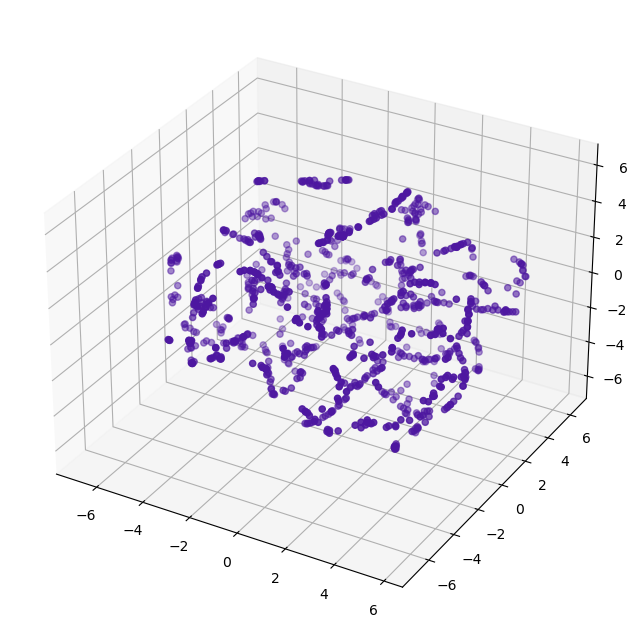

In [123]:
Axes3D

fig = plt.figure(figsize=(15, 8))

# Add 3D scatter plot
ax = fig.add_subplot(projection='3d')
ax.scatter(tsne.embedding_[:,0], tsne.embedding_[:,1], tsne.embedding_[:,2], color='#4D17A0')
plt.show()

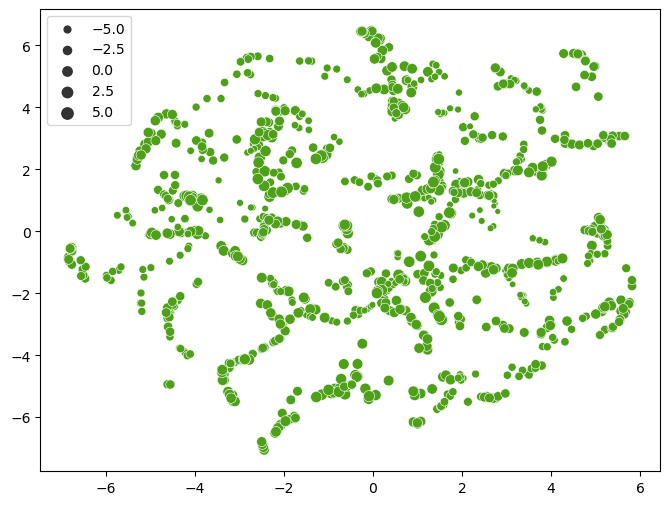

In [124]:
fig = plt.figure(figsize=(8, 6))
sns.scatterplot(x = tsne.embedding_[:,0], y = tsne.embedding_[:,1], size=tsne.embedding_[:,2],color='#4DA017')
plt.show()

### Principal Component Analysis
Principal component analysis (PCA) is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss. It does so by creating new uncorrelated variables that successively maximize variance.

In [125]:
# Manually pivot table as data is too large for in-built functions
def pivot_(df):
    new_dict = {'movieId':sorted(set(df.index))}
    pivoted = pd.DataFrame(new_dict)
    tagids = sorted(set(df['tagId']))
    for Id in range(len(tagids)):
        pivoted[f'{Id+1}'] = list(df[df['tagId'] == Id+1]['relevance'])
    return pivoted

In [126]:
pca_data_pivoted = pivot_(genome_scores).set_index('movieId')
pca_data_pivoted.shape

(13816, 1128)

In [127]:
pca_data_pivoted.columns = list(genome_tags['tag'])

In [128]:
pca_data_pivoted.head()

,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,0.03075,...,0.04050,0.01425,0.03050,0.03500,0.14125,0.05775,0.03900,0.02975,0.08475,0.02200
2,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,0.05250,...,0.05250,0.01575,0.01250,0.02000,0.12225,0.03275,0.02100,0.01100,0.10525,0.01975
3,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.0285,0.03875,...,0.06275,0.01950,0.02225,0.02300,0.12200,0.03475,0.01700,0.01800,0.09100,0.01775
4,0.03425,0.03800,0.04050,0.03100,0.06500,0.03575,0.02900,0.08650,0.0320,0.03150,...,0.05325,0.02800,0.01675,0.03875,0.18200,0.07050,0.01625,0.01425,0.08850,0.01500
5,0.04300,0.05325,0.03800,0.04100,0.05400,0.06725,0.02775,0.07650,0.0215,0.02975,...,0.05350,0.02050,0.01425,0.02550,0.19225,0.02675,0.01625,0.01300,0.08700,0.01600


In [129]:
features = [col for col in pca_data_pivoted.columns]

In [131]:
#cf.set_config_file(offline=True, world_readable=True, theme='white')
#columns = random.sample(range(0, 1129), 20)
#pca_data_pivoted.iloc[:,columns].iplot(kind='box', title="Boxplots of Features (Unscaled)")

In [132]:
def scaler(df):
    """
    Scales data.
    """
    scaler = StandardScaler(with_std=True)
    scaled_data = scaler.fit_transform(df)
    return scaled_data

In [133]:
pca_scaled = scaler(pca_data_pivoted)
scaled_pca = pd.DataFrame(pca_scaled, index = pca_data_pivoted.index, columns = pca_data_pivoted.columns)

In [134]:
#cf.set_config_file(offline=True, world_readable=True, theme='white')
# using plotly to plot the boxplot
#scaled_pca.iloc[:,columns].iplot(kind='box', title="Boxplots of Features (Scaled)")

Text(0, 0.5, 'Cumulative explained variance')

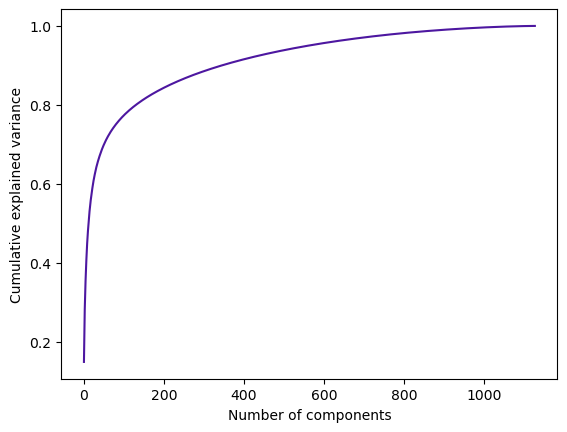

In [135]:
# define PCA object
pca = PCA()

# fit the PCA model to our data and apply the dimensionality reduction 
prin_comp = pca.fit_transform(pca_data_pivoted[features])

# create a dataframe containing the principal components
pca_df = pd.DataFrame(data = prin_comp,
                      index=pca_data_pivoted.index, columns=pca_data_pivoted.columns
                     )

# plot line graph of cumulative variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_),color='#4D17A0')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [136]:
pca_75 = PCA(.80)
pca_75_df = pca_75.fit_transform(pca_data_pivoted)
print(round(pca_75.explained_variance_ratio_.sum()*100, 1),
      "% of variance explained by",
      pca_75.n_components_,
      "components.")

80.0 % of variance explained by 131 components.


The cummulative explained variance shows an initially steep then gradual curve and not the sharp elbow we were expecting. This could be a result of the genomes already having been chosen as the principle components of movies. However we can see that 80% of the variance in the movie dataset is explained by 131 components. We should use only these components for computatonal efficiency in a content based mode

In [137]:
pca_75_df = pd.DataFrame(pca_75_df, index = pca_data_pivoted.index)
pca_75_df.head()

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.796514,2.212839,-2.489444,1.624747,0.984763,1.168046,-0.203300,1.659382,-0.675962,-1.251265,...,-0.166531,0.023522,0.124865,0.091553,-0.014734,-0.082235,0.029796,-0.077556,-0.072878,-0.094931
2,-1.541922,1.597864,-1.113613,1.302526,-0.196336,0.191809,-0.026161,1.208987,-0.369388,-0.483199,...,0.026369,-0.088038,0.113610,-0.050569,-0.015265,0.067904,0.026488,0.013665,0.079228,-0.130822
3,-1.506092,-0.010220,-0.605981,-0.316252,0.330972,0.334078,0.048253,0.010072,-0.042318,0.040345,...,0.060794,-0.101178,0.033077,0.073228,-0.010904,-0.094919,0.019864,0.004834,0.059739,0.035608
4,-1.293604,-0.775662,-0.926582,-0.384600,0.103713,-0.345682,0.683775,0.218370,-0.159426,0.639183,...,-0.036119,-0.145511,0.102927,-0.103027,0.005975,0.053953,0.044405,-0.202070,-0.158430,0.007054
5,-1.694557,-0.185986,-1.204239,-0.149549,0.470713,0.053199,0.385026,0.302557,-0.133082,-0.083749,...,0.016023,0.069098,-0.017486,0.005937,0.127657,-0.019529,-0.327449,-0.137680,-0.053703,0.065995


### Cluster Analysis

In [138]:
# Manually implement the WCSS
def within_cluster_variation(df, label_col='cluster_label'):
    """
    Manually implements the WCSS.
    """
    centroids = df.groupby(label_col).mean()
    out = 0
    for label, point in centroids.iterrows():
        df_features = df[df[label_col] == label].drop(label_col, axis=1)
        out += (df_features - point).pow(2).sum(axis=1).sum()
    return out

In [139]:
# let's try everything between 2 and 18 clusters where 18 is the number of genres
n_clusters = np.arange(2, 19)

# store errors for each value of k
errors = []

# for i between 2 and 19
for k in n_clusters:
    print(f'training model with {k} clusters')
    # perform k-means clustering
    km = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    km.fit(pca_75_df)
    
    # measure BCSS
    print(f'evaluating model with {k} clusters')
    y_preds = km.predict(pca_75_df)
    pca_75_df = pd.DataFrame(pca_75_df)
    pca_75_df['cluster_label'] = y_preds
    errors.append(within_cluster_variation(pca_75_df, 'cluster_label'))
    print(errors[-1])

training model with 2 clusters
evaluating model with 2 clusters
167610.09951547848
training model with 3 clusters
evaluating model with 3 clusters
159202.04716452214
training model with 4 clusters
evaluating model with 4 clusters
153979.41324329143
training model with 5 clusters
evaluating model with 5 clusters
149074.88861234672
training model with 6 clusters
evaluating model with 6 clusters
145054.80661973805
training model with 7 clusters
evaluating model with 7 clusters
141701.3376691966
training model with 8 clusters
evaluating model with 8 clusters
139251.25169642275
training model with 9 clusters
evaluating model with 9 clusters
137033.02607491956
training model with 10 clusters
evaluating model with 10 clusters
135148.42670872988
training model with 11 clusters
evaluating model with 11 clusters
132591.0326160025
training model with 12 clusters
evaluating model with 12 clusters
130792.51569023248
training model with 13 clusters
evaluating model with 13 clusters
129498.1890617720

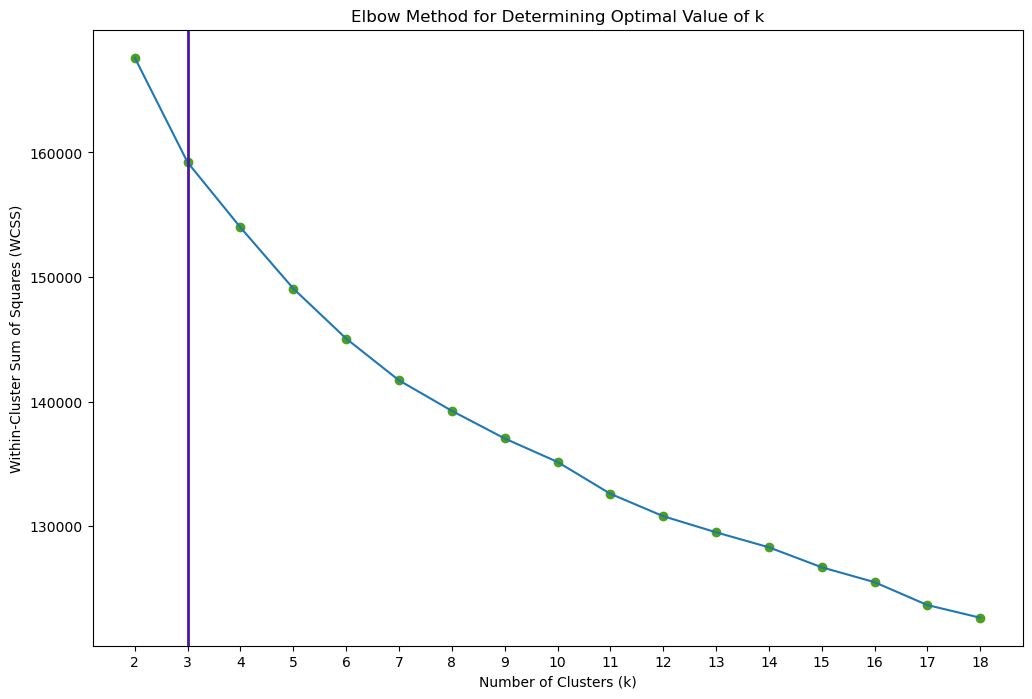

In [140]:
plt.figure(figsize=(12,8))
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Determining Optimal Value of k')
plt.scatter(n_clusters, errors, color="#4DA017")
plt.plot(n_clusters, errors)
plt.xticks(n_clusters)
plt.axvline(x=3, color='#4D17A0', lw=2)
plt.show()

In [141]:
K = 3
# Remember to set the random state for reproducibility
km = KMeans(n_clusters=K, verbose=0, random_state=42)
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(pca_75_df)
print("done in %0.3fs" % (time() - t0))

Clustering sparse data with KMeans(n_clusters=3, random_state=42)
done in 0.498s


In [142]:
# Obtain cluster memberships for each item in the data
y_preds = km.predict(pca_75_df)
pca_75_df['cluster_label'] = y_preds
centers = km.cluster_centers_

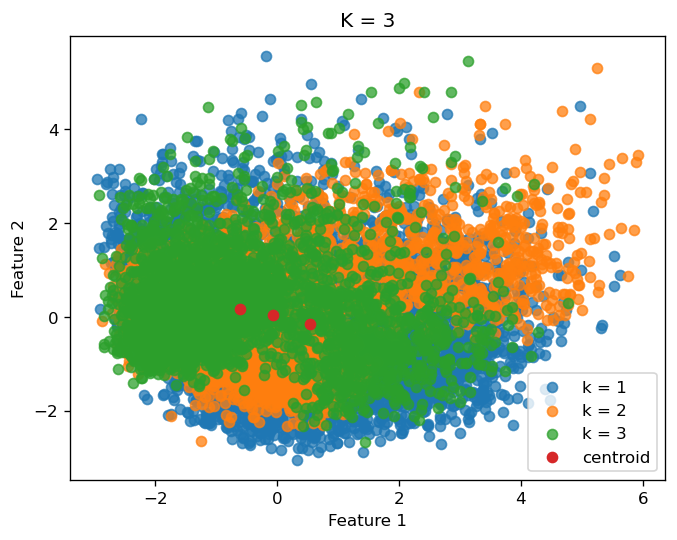

In [143]:
plt.figure(dpi=120)
for k in range(K):
    x1 = pca_75_df[pca_75_df['cluster_label'] == k][0]
    x2 = pca_75_df[pca_75_df['cluster_label'] == k][1]
    plt.scatter(x1, x2, label="k = "+str(k+1),alpha=0.75)
# Show cluster centroid locations    
plt.scatter(centers[:,0],centers[:,1],label="centroid")
plt.legend()
plt.title(f"K = {K}")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

<a id="modelling"></a>
## 5. Modelling

To reduce computation time, we train and evaluate the following models on a 100k subset of the data. The best performing model will be trained on the whole dataset to predict the ratings for the final submission file.

In [144]:
# Load the 100k dataset
train_df.drop('timestamp', axis=1, inplace=True)
train_subset = train_df[:100000]
reader = Reader(rating_scale=(train_subset['rating'].min(), train_subset['rating'].max()))
data = Dataset.load_from_df(train_subset[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=42)

NameError: name 'Reader' is not defined

### Collaborative Filtering

Collaborative filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users. It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user.

#### SVD

The Singular Value Decomposition algorithm is a matrix factorization technique which reduces the number of features of a dataset and was popularized by Simon Funk during the [Neflix Prize](https://en.wikipedia.org/wiki/Netflix_Prize) contest. In the matrix structure, each row represents a user and each column represents a movie. The matrix elements are ratings that are given to movies by users.

In [145]:
svd_test = SVD(n_epochs = 50, n_factors = 200, init_std_dev = 0.05, random_state=42)
svd_test.fit(trainset)
predictions = svd_test.test(testset)
# Calculate RMSE
svd_rmse = accuracy.rmse(predictions)

NameError: name 'SVD' is not defined

#### NormalPredictor  
The Normal Predictor algorithm predicts a random rating for each movie based on the distribution of the training set, which is assumed to be normal.

In [146]:
np_test = NormalPredictor()
np_test.fit(trainset)
predictions = np_test.test(testset)
# Calculate RMSE
np_rmse = accuracy.rmse(predictions)

NameError: name 'NormalPredictor' is not defined

#### BaselineOnly  
The Baseline Only algorithm predicts the baseline estimate for a given user and movie. A baseline is calculated using either Stochastic Gradient Descent (SGD) or Alternating Least Squares (ALS).

In [147]:
bsl_options = {'method': 'sgd','n_epochs': 40}
blo_test = BaselineOnly(bsl_options=bsl_options)
blo_test.fit(trainset)
predictions = blo_test.test(testset)
# Calculate RMSE
blo_rmse = accuracy.rmse(predictions)

NameError: name 'BaselineOnly' is not defined

#### NMF  
NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. The optimization procedure is a (regularized) stochastic gradient descent with a specific choice of step size that ensures non-negativity of factors, provided that their initial values are also positive.

In [148]:
nmf_test = NMF()
nmf_test.fit(trainset)
predictions = nmf_test.test(testset)
# Calculate RMSE
nmf_rmse = accuracy.rmse(predictions)

NameError: name 'NMF' is not defined

#### SlopeOne  
The SlopeOne algorithm is a simple yet accurate collaborative filtering algorithm that uses a simple linear regression model to solve the data sparisity problem. 

In [ ]:
slo_test = SlopeOne()
slo_test.fit(trainset)
predictions = slo_test.test(testset)
# Calculate RMSE
slo_rmse = accuracy.rmse(predictions)

#### CoClustering  
The Co-clustering algorithm assigns clusters using a straightforward optimization method, much like k-means.

In [ ]:
cc_test = CoClustering(random_state=42)
cc_test.fit(trainset)
predictions = cc_test.test(testset)
# Calculate RMSE
cc_rmse = accuracy.rmse(predictions)

### Content-based Filtering  
Content-based filtering, also referred to as cognitive filtering, recommends items based on a comparison between the content of the items and a user profile. The content of each item is represented as a set of descriptors or terms, typically the words that occur in a document. In the following section, the model uses genres as keywords to recommend similar movies based on input from a user. The model was not used to predict ratings for the testing data, as it is too computationally expensive.

In [ ]:
def data_preprocessing(subset_size):
    """Prepare data for use within Content filtering algorithm.
    Pandas Dataframe
        Subset of movies selected for content-based filtering.

    """
    # Split genre data into individual words.
    movies['keyWords'] = movies['genres'].str.replace('|', ' ')
    # Subset of the data
    movies_subset = movies[:subset_size]
    return movies_subset
 
def content_model(movie_list,top_n=10): 
    """Performs Content filtering based upon a list of movies supplied
       by the app user.
    """
    # Initializing the empty list of recommended movies
    data = data_preprocessing(2000)
    # Instantiating and generating the count matrix
    count_vec = CountVectorizer()
    count_matrix = count_vec.fit_transform(data['keyWords'])
    indices = pd.Series(data['title'])
    cosine_sim = cosine_similarity(count_matrix, count_matrix)
    cosine_sim = pd.DataFrame(cosine_sim, index = data.index, columns = data.index)
    # Getting the index of the movie that matches the title
    idx_1 = indices[indices == movie_list[0]].index[0]
    idx_2 = indices[indices == movie_list[1]].index[0]
    idx_3 = indices[indices == movie_list[2]].index[0]
    # Creating a Series with the similarity scores in descending order
    rank_1 = cosine_sim[idx_1]
    rank_2 = cosine_sim[idx_2]
    rank_3 = cosine_sim[idx_3]
    # Calculating the scores
    score_series_1 = pd.Series(rank_1).sort_values(ascending = False)
    score_series_2 = pd.Series(rank_2).sort_values(ascending = False)
    score_series_3 = pd.Series(rank_3).sort_values(ascending = False)
    # Getting the indexes of the 10 most similar movies
    listings = score_series_1.append(score_series_2).append(score_series_3).sort_values(ascending = False)
    # Store movie names
    recommended_movies = []
    # Appending the names of movies
    top_50_indexes = list(listings.iloc[1:50].index)
    # Removing chosen movies
    top_indexes = np.setdiff1d(top_50_indexes,[idx_1,idx_2,idx_3])
    for i in top_indexes[:top_n]:
        recommended_movies.append(list(movies['title'])[i])
    return recommended_movies

In [ ]:
movies = movies_df.dropna()
movie_list = ['Grumpier Old Men (1995)','Ace Ventura: When Nature Calls (1995)','Father of the Bride Part II (1995)']
content_model(movie_list,top_n=10)

<a id="evaluation"></a>
## 6. Performance Evaluation

We built and tested six different collaborative filtering models and compared their performance using a statistical measure known as the root mean squared error (**RMSE**), which determines the average squared difference between the estimated values and the actual value. A low RMSE value indicates high model accuracy.

### Root Mean Squared Error (RMSE):
$$RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$   

In [ ]:
# Compare RMSE values between models
fig,axis = plt.subplots(figsize=(8, 5))
rmse_x = ['SVD','NormalPredictor','BaselineOnly','NMF','SlopeOne','CoClustering']
rmse_y = [svd_rmse,np_rmse,blo_rmse,nmf_rmse,slo_rmse,cc_rmse]
ax = sns.barplot(x=rmse_x, y=rmse_y,palette='brg',edgecolor='black')
plt.title('RMSE Value Per Collaborative-based Filtering Model',fontsize=14)
plt.xticks(rotation=90)
plt.ylabel('RMSE')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height(), round(p.get_height(),2), fontsize=12, ha="center", va='bottom')
    
plt.show()

### Cross Validation

Cross validation is a technique used to test the accuracy of a model's prediction on unseen data (validation sets). This is important because it can assist in picking up issues such as over/underfitting and selection bias. We used the K-fold technique to perform cross validation on our two best perfoming models, i.e. **SVD** and **BaselineOnly**.

In [ ]:
svd_test = SVD(n_epochs = 30, n_factors = 200, init_std_dev = 0.05, random_state=42)
# Run 5-fold cross-validation and print results
a = cross_validate(svd_test, data, measures=['RMSE'], cv=5, verbose=True)

**BaselineOnly**

In [ ]:
bsl_options = {'method': 'sgd','n_epochs': 30}
blo_test = BaselineOnly(bsl_options=bsl_options)
# Run 5-fold cross-validation and print results
b = cross_validate(blo_test, data, measures=['RMSE'], cv=5, verbose=True)

<a id="analysis"></a>
## 7. Model Analysis

In [ ]:
# Load the 100k dataset
train_subset = train_df[:100000]
reader = Reader(rating_scale=(train_subset['rating'].min(), train_subset['rating'].max()))
data = Dataset.load_from_df(train_subset[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=42)

### Hyperparameter Tuning 

Hyperparameter tuning is the process by which a set of ideal hyperparameters are chosen for a model. A hyperparameter is a parameter for which the value is set manually and tuned to control the algorithm's learning process. We tested multiple parameters for our best performing model (i.e. **SVD**).

In [ ]:
param_grid = {'n_epochs':[40], #[30,40,50],
              'n_factors':[400], #[100,200,300,400],
              'init_std_dev':[0.005], #[0.001,0.005,0.05,0.1],
              'random_state':[42]} 
grid_SVD = GridSearchCV(SVD, cv=5, measures=['rmse'], param_grid=param_grid, n_jobs=-1)
grid_SVD.fit(data)
print('***Best score:***')
print(grid_SVD.best_score['rmse'])
print('***Best parameters:***')
print(grid_SVD.best_params['rmse'])

In [ ]:
svd_test = SVD(n_epochs = 40, n_factors = 400, init_std_dev = 0.005, random_state=42)
svd_test.fit(trainset)
predictions = svd_test.test(testset)
# Calculate RMSE
svd_rmse = accuracy.rmse(predictions)

In [ ]:
# Predicted Target Values vs. Actual Target Values
new_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in testset:
    new_df.loc[i] = [uid, iid, rating]
    i = i+1
true = new_df['rating']
pred = []
for i in predictions:
    pred.append(i.est)
fig,axis = plt.subplots(figsize=(8, 5))
sns.boxplot(x=true, y=pred, palette="brg")
plt.title("Predicted Target Values vs. Actual Target Values", fontsize=14)
plt.xlabel("Actual Target Values")
plt.ylabel("Predicted Target Values")
plt.show()

In [ ]:
#Save model
model_save_path = "SVD.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(svd,file)

<a id="conclusion"></a>
## 8. Conclusion

In this project, we succeeded in building an unsupervised machine learning model that is able to recommend movies based on content-based or collaborative filtering and is capable of accurately predicting how a user will rate a movie they have not yet viewed, based on their historical preferences. Our top performing model has a root mean squared error (RMSE) of 0.78, based on a testing set submitted to the EDSA [Kaggle](https://www.kaggle.com/competitions/edsa-movie-recommendation-2022/leaderboard) competition.  


The singular value decomposition (SVD) algorithm is a baseline approach to recommender systems, as it has a broad range of applications including dimensionality reduction, solving linear inverse problems, and data fitting. The SVD algorithm generally performs better on large datasets compared to some other models as it decomposes a matrix into constituent arrays of feature vectors corresponding to each row and each column.

<a id="save"></a>
## 9. Saving Output for submission

In [ ]:
# Train model on whole dataset
# reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))
# data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
# trainset = data.build_full_trainset()
# svd = SVD(n_epochs = 40, n_factors = 400, init_std_dev = 0.005, random_state=42, verbose=True)
# svd.fit(trainset)

# # Create Kaggle submission file
# predictions = []
# for i, row in test_df.iterrows():
#     x = (svd.predict(row.userId, row.movieId))
#     pred = x[3]
#     predictions.append(pred)
# test_df['Id'] = test_df['userId'].map(str) +'_'+ test_df['movieId'].map(str)
# results = pd.DataFrame({"Id":test_df['Id'],"rating": predictions})
# results.to_csv("Team_GM4_submission.csv", index=False)

In [ ]:
# Save model
model_save_path = "SVD.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(svd,file)

<a id="ref"></a>
## 10. References